# 3A.mr - PIG et JSON et streaming avec les données vélib (correction)

Correction.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Récupération des données

Le code suivant télécharge les données nécessaires [data_velib_paris_2014-11-11_22-23.zip](http://www.xavierdupre.fr/enseignement/complements/data_velib_paris_2014-11-11_22-23.zip).

In [2]:
import pyensae
import os, datetime
if not os.path.exists("velib"):
    os.mkdir("velib")
files=pyensae.download_data("data_velib_paris_2014-11-11_22-23.zip", website="xdtd", whereTo="velib")
files[:2]

['velib\\paris.2014-11-11_22-00-18.331391.txt',
 'velib\\paris.2014-11-11_22-01-17.859194.txt']

## Connexion au cluster


In [3]:
import pyensae
%load_ext pyensae
%load_ext pyenbc
from pyquickhelper.ipythonhelper import open_html_form
params={"server":"df...fr", "username":"", "password":""}
open_html_form(params=params,title="server + credentials", key_save="params")

In [4]:
import pyensae
%load_ext pyensae
password = params["password"]
server = params["server"]
username = params["username"]
client = %remote_open
client

## Exercice 1 : convertir les valeurs numériques

Le programme suivant prend comme argument les colonnes à extraire des fichiers textes qui sont enregistrés au format "python".

In [5]:
%%PYTHON stream_json.py

import sys, datetime
cols = [ _ for _ in sys.argv if ".py" not in _ ]
for row in sys.stdin:
    row = row.strip()
    if len(row) == 0 :
        continue
    js = eval(row)
    for station in js:
        vals = [ str(station[c]) for c in cols ]
        sys.stdout.write(",".join(vals))
        sys.stdout.write("\n")
        sys.stdout.flush()

On vérifie qu'il fonctionne en lui faisant ingérer les deux lignes suivantes :

In [6]:
%%runpy stream_json.py name status
[{'address': 'RUE DES CHAMPEAUX (PRES DE LA GARE ROUTIERE) - 93170 BAGNOLET', 'collect_date': datetime.datetime(2014, 11, 11, 22, 2, 18, 47270), 'lng': 2.416170724425901, 'contract_name': 'Paris', 'name': '31705 - CHAMPEAUX (BAGNOLET)', 'banking': 0, 'lat': 48.8645278209514, 'bonus': 0, 'status': 'OPEN', 'available_bikes': 1, 'last_update': datetime.datetime(2014, 11, 11, 21, 55, 22), 'number': 31705, 'available_bike_stands': 49, 'bike_stands': 50}]
[{'address': 'RUE DES CHAMPEAUX (PRES DE LA GARE ROUTIERE) - 93170 BAGNOLET', 'collect_date': datetime.datetime(2014, 11, 11, 22, 2, 18, 47270), 'lng': 2.416170724425901, 'contract_name': 'Paris', 'name': '31705 - CHAMPEAUX (BAGNOLET)', 'banking': 0, 'lat': 48.8645278209514, 'bonus': 0, 'status': 'OPEN', 'available_bikes': 1, 'last_update': datetime.datetime(2014, 11, 11, 21, 55, 22), 'number': 31705, 'available_bike_stands': 49, 'bike_stands': 50}]

On écrit le script PIG qui utilise plus de colonnes :

In [7]:
%%PIG json_velib.pig

DEFINE pystream `python stream_json.py available_bike_stands available_bikes lat lng name status` 
   SHIP ('stream_json.py') INPUT(stdin USING PigStreaming(',')) OUTPUT (stdout USING PigStreaming(',')) ;

jspy = LOAD 'velib_py/*.txt' USING PigStorage('\t') AS (arow:chararray);

matrice = STREAM jspy THROUGH pystream AS 
                (   available_bike_stands:int, 
                    available_bikes:int, 
                    lat:double, 
                    lng:double, 
                    name:chararray, 
                    status:chararray) ;

STORE matrice INTO 'velib_py_results/firstjob' USING PigStorage('\t') ;

On supprime la précédente exécution si besoin puis on vérifie que le répertoire contenant les résultats est vide :

In [8]:
if client.dfs_exists("velib_py_results/firstjob"):
    client.dfs_rm("velib_py_results/firstjob", recursive=True)
%dfs_mkdir velib_py_results

("Moved: 'hdfs://nameservice1/user/xavierdupre/velib_py_results/firstjob' to trash at: hdfs://nameservice1/user/xavierdupre/.Trash/Current\n",
 '14/11/23 20:35:18 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 1440 minutes, Emptier interval = 0 minutes.\n')

In [9]:
%dfs_ls velib_py_results/

,attributes,code,alias,folder,size,date,time,name


In [10]:
%pig_submit json_velib.pig stream_json.py -r redirection

In [11]:
%remote_cmd tail redirection.pig.err

On récupère les informations qu'on affiche sous forme de dataframe :

In [12]:
if os.path.exists("velib_exo1.txt") : os.remove("velib_exo1.txt")
client.download_cluster("velib_py_results/firstjob","velib_exo1.txt", merge=True)

'velib_py_results/firstjob'

In [13]:
import pandas
df = pandas.read_csv("velib_hd.txt", sep="\t",names=["available_bike_stands","available_bikes","lat","lng","name","status"])
df.head()

,available_bike_stands,available_bikes,lat,lng,name,status
0,47,3,48.864528,2.416171,31705 - CHAMPEAUX (BAGNOLET),OPEN
1,5,28,48.872420,2.348395,10042 - POISSONNIÈRE - ENGHIEN,OPEN
2,42,1,48.882149,2.319860,08020 - METRO ROME,OPEN
3,5,31,48.868217,2.330494,01022 - RUE DE LA PAIX,OPEN
4,20,5,48.893269,2.412716,35014 - DE GAULLE (PANTIN),OPEN


## Exercice 2 : stations fermées
    
Les stations fermées ne le sont pas tout le temps. On veut calculer le ratio minutes/stations fermées / total des minutes/stations. Le script python permettant de lire les données ne change pas, il suffit juste de déclarer les sorties numériques comme telles. Quelques détails sur les tables :

* ``jspy`` : contient les données brutes dans une liste de fichiers
* ``matrice`` : d'après le job qui précède, la table contient une ligne par stations et par minute, chaque ligne décrit le status de la station
* ``grstation`` : table ``matrice`` groupée par status
* ``fermees`` : pour chaque groupe, on aggrégé le nombre de minutes multipliés par le nombre de vélos
* ``gr*,dist*`` : distribution du nombre de stations (Y) en fonction du nombre de vélos ou places disponibles

En cas d'exécution précédentes :

In [14]:
%dfs_rmr velib_py_results/fermees.txt
%dfs_rmr velib_py_results/distribution_bikes.txt
%dfs_rmr velib_py_results/distribution_stands.txt

("Moved: 'hdfs://nameservice1/user/xavierdupre/velib_py_results/distribution_stands.txt' to trash at: hdfs://nameservice1/user/xavierdupre/.Trash/Current\n",
 '14/11/23 21:33:49 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 1440 minutes, Emptier interval = 0 minutes.\n')

In [15]:
%%PIG json_fermee.pig

DEFINE pystream `python stream_json.py available_bike_stands available_bikes lat lng name status` 
   SHIP ('stream_json.py') INPUT(stdin USING PigStreaming(',')) OUTPUT (stdout USING PigStreaming(',')) ;

jspy = LOAD 'velib_py/*.txt' USING PigStorage('\t') AS (arow:chararray);

matrice = STREAM jspy THROUGH pystream AS 
                (   available_bike_stands:int, 
                    available_bikes:int, 
                    lat:double, 
                    lng:double, 
                    name:chararray, 
                    status:chararray) ;
                
grstation = GROUP matrice BY status ;  

fermees = FOREACH grstation GENERATE
                 group
                ,SUM(matrice.available_bikes) AS available_bikes
                ,SUM(matrice.available_bike_stands) AS available_bike_stands 
                ;

gr_av   = GROUP matrice BY available_bikes ;
dist_av = FOREACH gr_av GENERATE group, COUNT(matrice) ;
gr_pl   = GROUP matrice BY available_bike_stands ;
dist_pl = FOREACH gr_pl GENERATE group, COUNT(matrice) ;

STORE fermees INTO 'velib_py_results/fermees.txt' USING PigStorage('\t') ;
STORE dist_av INTO 'velib_py_results/distribution_bikes.txt' USING PigStorage('\t') ;
STORE dist_pl INTO 'velib_py_results/distribution_stands.txt' USING PigStorage('\t') ;

In [16]:
%pig_submit json_fermee.pig stream_json.py -r redirection

In [17]:
%remote_cmd tail redirection.pig.err 

In [18]:
%dfs_ls velib_py_results

,attributes,code,alias,folder,size,date,time,name,isdir
0,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-11-23,20:54,velib_py_results/distribution_bikes.txt,True
1,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-11-23,20:54,velib_py_results/distribution_stands.txt,True
2,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-11-23,20:36,velib_py_results/firstjob,True


In [19]:
if os.path.exists("distribution_bikes.txt") : os.remove("distribution_bikes.txt")
%remote_down_cluster_merge velib_py_results/distribution_bikes.txt distribution_bikes.txt

'distribution_bikes.txt'

In [20]:
import pandas
df = pandas.read_csv("distribution_bikes.txt", sep="\t", names=["nb_velos", "nb_stations_minutes"])
df.head()

,nb_velos,nb_stations_minutes
0,0,8445
1,1,6589
2,2,4825
3,3,3793
4,4,2839


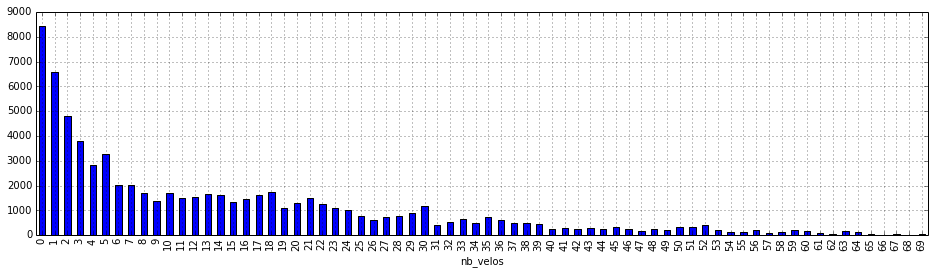

In [21]:
df.plot(x="nb_velos",y="nb_stations_minutes",kind="bar",figsize=(16,4))

In [22]:
if os.path.exists("distribution_stands.txt") : os.remove("distribution_stands.txt")
%remote_down_cluster_merge velib_py_results/distribution_stands.txt distribution_stands.txt

'distribution_stands.txt'

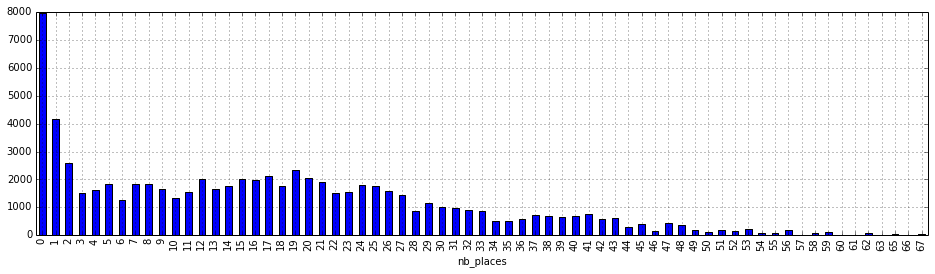

In [23]:
df = pandas.read_csv("distribution_stands.txt", sep="\t", names=["nb_places", "nb_stations_minutes"])
df.plot(x="nb_places",y="nb_stations_minutes",kind="bar",figsize=(16,4))

In [24]:
if os.path.exists("fermees.txt") : os.remove("fermees.txt")
%remote_down_cluster_merge velib_py_results/fermees.txt fermees.txt

'fermees.txt'

In [25]:
df = pandas.read_csv("fermees.txt", sep="\t", names=["status", "nb_velos_stations_minutes", "nb_places_stations_minutes"])
df=df.set_index("status")
df = df.T
df["%close"] = df.CLOSED / (df.CLOSED + df.OPEN)
df

status,OPEN,CLOSED,%close
nb_velos_stations_minutes,1048654,3060,0.002910
nb_places_stations_minutes,1255146,120,0.000096


Ce dernier tableau n'est vrai que dans la mesure où les nombres reportées sont fiables lorsque les stations sont fermées.

## Exercice 3 : stations fermées, journée complète
    
Appliquer cela à une journée complète revient à lancer le même job sur des données plus grandes. On verra bientôt commencer éviter de recopier le job une seconde fois (introduisant une source potentielle d'erreur).

In [26]:
%dfs_ls /user/xavierdupre/

,attributes,code,alias,folder,size,date,time,name,isdir
0,drwx------,-,xavierdupre,xavierdupre,0,2014-11-23,17:55,/user/xavierdupre/.Trash,True
1,drwx------,-,xavierdupre,xavierdupre,0,2014-11-23,21:41,/user/xavierdupre/.staging,True
2,-rw-r--r--,3,xavierdupre,xavierdupre,132727,2014-11-16,02:37,/user/xavierdupre/ConfLongDemo_JSI.small.examp...,False
3,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-11-16,02:38,/user/xavierdupre/ConfLongDemo_JSI.small.examp...,True
4,-rw-r--r--,3,xavierdupre,xavierdupre,461444,2014-11-20,01:33,/user/xavierdupre/paris.2014-11-11_22-00-18.33...,False
5,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-11-20,23:43,/user/xavierdupre/unitest2,True
6,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-11-23,21:42,/user/xavierdupre/unittest,True
7,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-11-23,21:41,/user/xavierdupre/unittest2,True
8,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-11-20,01:53,/user/xavierdupre/velib_1hjs,True
9,drwxr-xr-x,-,xavierdupre,xavierdupre,0,2014-11-21,01:17,/user/xavierdupre/velib_py,True


In [27]:
%%PIG json_fermee.pig

DEFINE pystream `python stream_json.py available_bike_stands available_bikes lat lng name status` 
   SHIP ('stream_json.py') INPUT(stdin USING PigStreaming(',')) OUTPUT (stdout USING PigStreaming(',')) ;

jspy = LOAD '/user/xavierdupre/velib_several_days/*.txt' USING PigStorage('\t') AS (arow:chararray);

matrice = STREAM jspy THROUGH pystream AS 
                (   available_bike_stands:int, 
                    available_bikes:int, 
                    lat:double, 
                    lng:double, 
                    name:chararray, 
                    status:chararray) ;
                
grstation = GROUP matrice BY status ;  

fermees = FOREACH grstation GENERATE
                 group
                ,SUM(matrice.available_bikes) AS available_bikes
                ,SUM(matrice.available_bike_stands) AS available_bike_stands 
                ;

gr_av   = GROUP matrice BY available_bikes ;
dist_av = FOREACH gr_av GENERATE group, COUNT(matrice) ;
gr_pl   = GROUP matrice BY available_bike_stands ;
dist_pl = FOREACH gr_pl GENERATE group, COUNT(matrice) ;

STORE fermees INTO 'velib_py_results_3days/fermees.txt' USING PigStorage('\t') ;
STORE dist_av INTO 'velib_py_results_3days/distribution_bikes.txt' USING PigStorage('\t') ;
STORE dist_pl INTO 'velib_py_results_3days/distribution_stands.txt' USING PigStorage('\t') ;

In [28]:
%pigsubmit json_fermee.pig stream_json.py redirection

In [29]:
%remote_cmd tail redirection.err

In [30]:
%dfs_ls velib_py_results_3days/*

,attributes,code,alias,folder,size,date,time,name,isdir
0,-rw-r--r--,3,xavierdupre,xavierdupre,0,2014-11-23,21:54,velib_py_results_3days/distribution_bikes.txt/...,False
1,-rw-r--r--,3,xavierdupre,xavierdupre,210,2014-11-23,21:54,velib_py_results_3days/distribution_bikes.txt/...,False
2,-rw-r--r--,3,xavierdupre,xavierdupre,208,2014-11-23,21:54,velib_py_results_3days/distribution_bikes.txt/...,False
3,-rw-r--r--,3,xavierdupre,xavierdupre,216,2014-11-23,21:54,velib_py_results_3days/distribution_bikes.txt/...,False
4,-rw-r--r--,3,xavierdupre,xavierdupre,0,2014-11-23,21:54,velib_py_results_3days/distribution_stands.txt...,False
5,-rw-r--r--,3,xavierdupre,xavierdupre,210,2014-11-23,21:54,velib_py_results_3days/distribution_stands.txt...,False
6,-rw-r--r--,3,xavierdupre,xavierdupre,208,2014-11-23,21:54,velib_py_results_3days/distribution_stands.txt...,False
7,-rw-r--r--,3,xavierdupre,xavierdupre,210,2014-11-23,21:54,velib_py_results_3days/distribution_stands.txt...,False
8,-rw-r--r--,3,xavierdupre,xavierdupre,0,2014-11-23,21:54,velib_py_results_3days/fermees.txt/_SUCCESS,False
9,-rw-r--r--,3,xavierdupre,xavierdupre,20,2014-11-23,21:54,velib_py_results_3days/fermees.txt/part-r-00000,False


On voit que le job a été distribué sur trois machines.

## Exercice 4 : astuces

Les erreurs de PIG ne sont pas très explicite surtout si elles se produisent dans le script python. Un moyen simple de débugger est d'attraper les exceptions produites par python et de les récupérer sous PIG (le reste du job est enlevé). On peut tout-à-fait imaginer ajouter la version de python installée sur le cluster ainsi que la liste de modules

In [31]:
%%PYTHON stream_json_err.py

import sys, os
for row in sys.stdin:
    sys.stdout.write(sys.executable + "\n")
    sys.stdout.write(str(sys.version) + "\n")
    sys.stdout.write(row + "\n")
    # pour obtenir les variables d'environnement
    #for k in os.environ:
    #    sys.stdout.write("%s=%s\n" % (k,os.environ[k]))
    sys.stdout.flush()

In [32]:
%%runpy stream_json_err.py
n'importe quoi

In [33]:
%%PIG test.pig

DEFINE pystream `python stream_json_err.py` 
   SHIP ('stream_json_err.py') INPUT(stdin USING PigStreaming(',')) OUTPUT (stdout USING PigStreaming(',')) ;

jspy = LOAD 'velib_py/*.txt' USING PigStorage('\t') AS (arow:chararray);
one = LIMIT jspy 1 ;
info = STREAM one THROUGH pystream AS (row:chararray) ;
STORE info INTO 'python_info2.txt' ;

In [34]:
%pig_submit test.pig stream_json_err.py -r redirection

In [35]:
%remote_cmd tail redirection.pig.err -n 5

In [36]:
if os.path.exists("python_info2.txt") : os.remove("python_info2.txt")
%remote_down_cluster_merge python_info2.txt python_info2.txt

'python_info2.txt'

In [37]:
%head python_info2.txt